In [1]:
# Skriptas užduoto ilgio sekų skaitymui iš MIT2ZIVE EKG įrašų plius papildomi skriptai

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from wfdb_plot import plot_items
from pathlib import Path
import sys

from mit2zive_util import read_show_seq_ext_mit2zive

def read_seq(rec_dir, all_beats_attr, idx, wl_side, wr_side):
# nuskaito EKG seką apie R dantelį: wl_side - iš kairės pusės, wr_side - iš dešinės pusės
    row = all_beats_attr.loc[idx]

    file_path = Path(rec_dir, str(row['userNr']) + '.npy')
    signal = np.load(file_path, mmap_mode='r')    

    signal_length = signal.shape[0]

    (seq_start, seq_end)  = get_seq_start_end(signal_length, row['sample'], wl_side, wr_side)
        
    # Praleidžiame per trumpas sekas įrašo pradžioje ir pabaigoje
    if (seq_start == None or seq_end == None):
        return None, None 
    else:    
        seq = signal[seq_start:seq_end]
        label = row['label']
    return seq, label


def get_seq_start_end(signal_length,i_sample,window_left_side,window_right_side):
    # Nustatome išskiriamos EKG sekos pradžią ir pabaigą
    seq_start = i_sample - window_left_side
    seq_end = i_sample + window_right_side
    if (seq_start < 0 or seq_end > signal_length):
        # print("\nseq_start: ", seq_start, " seq_end: ", seq_end)
        return (None,None)
    else:    
        return (seq_start, seq_end)


def plot_seq(rec_dir, all_beats_attr, idx, wl_side, wr_side, window_left_side_ext, window_right_side_ext):
# 'Išpjauname' užduoto ilgio seką ir sukuriame jos vaizdą
    row = all_beats_attr.loc[idx]
    userNr = str(row['userNr'])
    sample = row['sample']
    macro_annotation = row['symbol']
    # print(userNr, sample)

    fig = plt.figure(facecolor=(1, 1, 1), figsize=(18,3)) 
    ax = read_show_seq_ext_mit2zive(rec_dir, userNr, sample, wl_side, wr_side, 
                                                                window_left_side_ext, window_right_side_ext)
    if (ax == None):
        print(f"Sekai userNr: {userNr}  idx: {idx} negali suformuoti išplėstinio vaizdo")
    else:
        txt = f"'userNr:' {str(userNr)}  'idx:' {str(idx)}  'macro_annotation:' {macro_annotation}"
        plt.title(txt)
        plt.show()    


def read_show_seq_ext_mit2zive(rec_dir, subject, i_sample, win_ls, win_rs, win_ls_ext, win_rs_ext):
# Išpjauna užduoto ilgio seką iš mit2zive įrašo ir sukuria jos vaizdą su anotacijomis

# rec_dir - paciento EKG įrašų aplankas
# subject - paciento EKG įrašo numeris - int
# i_sample - R dantelio, kurio atžvilgiu formuojama seka, indeksas viso EKG įrašo reikšmių masyve - int
# win_ls - klasifikuojamo EKG segmento plotis iki R pūpsnio (iš kairės) 
# win_rs - klasifikuojamo EKG segmento plotis nuo R pūpsnio (iš dešinės)
# win_ls_ext - vaizduojamo EKG segmento plotis iki R pūpsnio (iš kairės) 
# win_rs_ext - vaizduojamo EKG segmento plotis už R pūpsnio (iš dešinės) 

    ax = plt.gca()
    
 # Nuskaitome visą paciento įrašą 
    file_path = Path(rec_dir, str(subject) + '.npy')
    signal = np.load(file_path, mmap_mode='r')    
    signal_length = signal.shape[0]

    # Nuskaitome paciento anotacijas ir jų indeksus
    file_path = Path(rec_dir, str(subject) + '.json')
    df = pd.read_json(file_path, orient = 'records')
    atr_sample = df['sampleIndex'].to_numpy()
    atr_symbol = df['annotationValue'].to_numpy()

    # surandame užduoto ilgio sekos pradžią ir pabaigą,
    # jei reikia - koreguojame
    seq_start, seq_end = get_seq_start_end(signal_length, i_sample, win_ls_ext, win_rs_ext)
    if (seq_start == None or seq_end == None):
        print("klaida!")
        return None

    # Išskiriame seką
    sequence = signal[seq_start:seq_end]

    # # suformuojame anotacijų žymes
    beat_symbols,beat_locs = get_symbol_list(atr_symbol,atr_sample, seq_start, seq_end)

    # deltax ir deltay simbolių pozicijų koregavimui
    min = np.amin(sequence)
    max = np.amax(sequence)
    deltay = (max - min)/20
    deltax = len(sequence)/100

    # suformuojame vaizdą
    x = np.arange(0, len(sequence), 1)
    ax.plot(x, sequence, color="#6c3376", linewidth=2)
    left_mark = i_sample - seq_start - win_ls
    right_mark = i_sample - seq_start + win_rs
    ax.axvline(x = left_mark, color = 'b', linestyle = 'dotted')
    ax.axvline(x = right_mark, color = 'b', linestyle = 'dotted')
    for i in range(len(beat_locs)):
        ax.annotate(beat_symbols[i],(beat_locs[i]-deltax,sequence[beat_locs[i]]+deltay))
    ax.set_ylim([min, max+2*deltay])
    
    return(ax)

def get_symbol_list(atr_symbols, atr_samples, seq_start, seq_end):
    # Surenkame išpjautos EKG sekos anotacijas ir jų indeksus sekoje
    # ir patalpiname sąraše.
    beat_locs = []
    beat_symbols = []

    for i in range(len(atr_samples)):
        if atr_samples[i] > seq_start and atr_samples[i] < seq_end:
            beat_symbols.append(atr_symbols[i])
            beat_locs.append(atr_samples[i]-seq_start)   
            # beat_locs.append(atr_samples[i])   

    return (beat_symbols,beat_locs)


def anotaciju_pasiskirstymas_v2(all_beats_attr, ind_lst=None, cols_pattern=None):
#  Skaičiuoja anotacijų pasiskirstymą
#  ind_lst - indeksų sąrašas, kuriuos reikia įtraukti į skaičiavimą

    if (ind_lst is not None):
        tmp_beats_attr = all_beats_attr.loc[all_beats_attr.index[ind_lst]]
        labels_table = pd.crosstab(index=tmp_beats_attr['userNr'], columns=tmp_beats_attr['symbol'], margins=True)
    else:
        labels_table = pd.crosstab(index=all_beats_attr['userNr'], columns=all_beats_attr['symbol'], margins=True)

    if (cols_pattern is not None):
        cols = list(labels_table.columns)
        cols_ordered = [s for s in cols_pattern if s in cols]
        labels_table = labels_table[cols_ordered]
    
    labels_sums = labels_table.sum(axis=1) 

    return labels_table, labels_sums
    
def print_stats(stats, arr_values):
    print(f'min: {stats.minmax[0]:.5f}, max: {stats.minmax[1]:.4f}  mean: {stats.mean:.5f}  standard: {np.std(arr_values):.5f}')
    print(f'variance: {stats.variance:.5f}  skewness: {stats.skewness:.5f}  kurtosis: {stats.kurtosis:.5f}')



my_os=sys.platform

print("OS in my system : ",my_os)

if my_os != 'linux':
    OS = 'Windows'
else:  
    OS = 'Ubuntu'

# Pasiruošimas

# Bendras duomenų aplankas, kuriame patalpintas subfolderis name_db

if OS == 'Windows':
    Duomenu_aplankas = 'C:\DI\Data\MIT&ZIVE'   # variantas: Windows
else:
    Duomenu_aplankas = '/home/kesju/DI/Data/MIT&ZIVE'   # arba variantas: UBUNTU, be Docker

# jei variantas Docker pasirenkame:
# Duomenu_aplankas = '/Data/MIT&ZIVE'

#  DUOM_VU duomenų aplankas
db_folder = 'DUOM_VU'

# Nuoroda į DUOM_VU duomenų aplanką
db_path = Path(Duomenu_aplankas, db_folder)

# Anotacijoms priskirtos klasės
selected_beats = {'N':0, 'S':1, 'V':2}

print("\nBendras MIT ir Zive duomenų aplankas: ", Duomenu_aplankas)
print("EKG įrašų aplankas: ", db_folder)


OS in my system :  win32

Bendras MIT ir Zive duomenų aplankas:  C:\DI\Data\MIT&ZIVE
EKG įrašų aplankas:  DUOM_VU


Pacientų nr.: [118, 209]
Pūpsnių atributų masyvo indeksų sąrašas: [30488, 57578, 57923, 56970, 58566, 30100, 30794, 31260, 57715, 30333]


Sekos anotacijos vieta laiko ašyje: 0:15:03.460000
idx = 30488  seq_1d.shape = (140,)  label = 0
min: -2.08500, max: 0.6575  mean: -0.81255  standard: 0.43458
variance: 0.19022  skewness: -0.69964  kurtosis: 3.54532


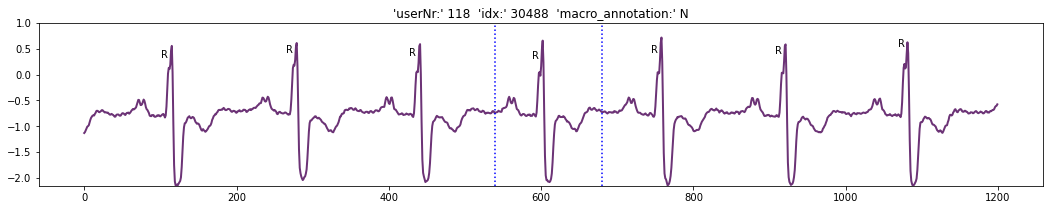

Sekos anotacijos vieta laiko ašyje: 0:15:30
idx = 57578  seq_1d.shape = (140,)  label = 0
min: -0.73818, max: 1.2505  mean: -0.16311  standard: 0.23475
variance: 0.05550  skewness: 3.40066  kurtosis: 16.64131


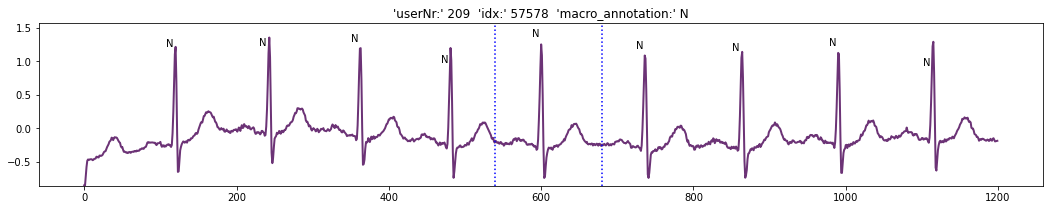

Sekos anotacijos vieta laiko ašyje: 0:19:08.555000
idx = 57923  seq_1d.shape = (140,)  label = 0
min: -0.75981, max: 1.0682  mean: -0.11344  standard: 0.19771
variance: 0.03937  skewness: 2.92883  kurtosis: 16.08693


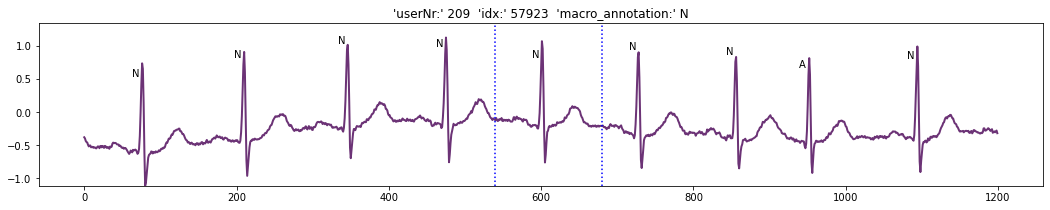

Sekos anotacijos vieta laiko ašyje: 0:09:46.225000
idx = 56970  seq_1d.shape = (140,)  label = 0
min: -0.77897, max: 1.0469  mean: -0.16282  standard: 0.21887
variance: 0.04825  skewness: 2.56013  kurtosis: 12.32293


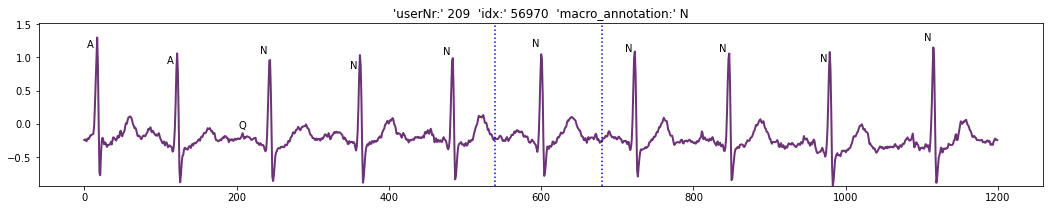

Sekos anotacijos vieta laiko ašyje: 0:25:54.880000
idx = 58566  seq_1d.shape = (140,)  label = 0
min: -0.75889, max: 1.2752  mean: -0.07888  standard: 0.24748
variance: 0.06169  skewness: 2.37180  kurtosis: 10.37226


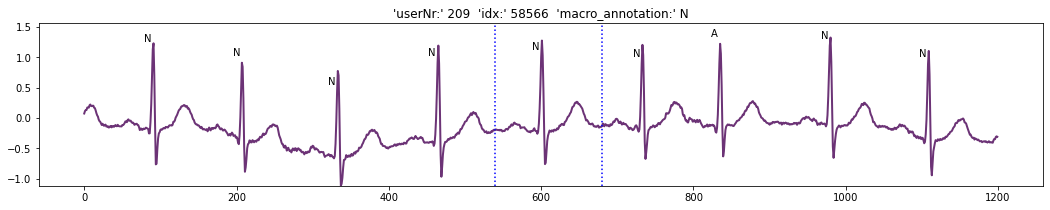

Sekos anotacijos vieta laiko ašyje: 0:09:55.740000
idx = 30100  seq_1d.shape = (140,)  label = 0
min: -2.04832, max: 0.6710  mean: -0.92805  standard: 0.38430
variance: 0.14875  skewness: 0.13418  kurtosis: 5.43950


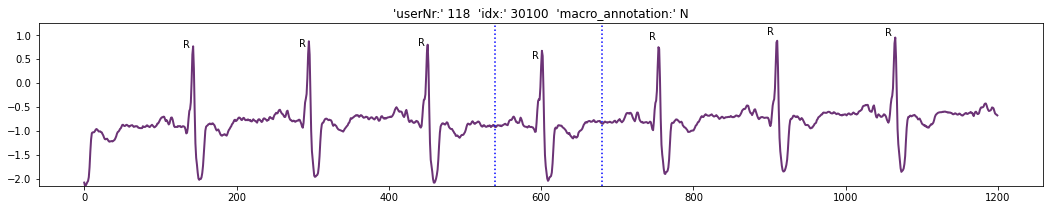

Sekos anotacijos vieta laiko ašyje: 0:19:11.625000
idx = 30794  seq_1d.shape = (140,)  label = 0
min: -2.01936, max: 0.7485  mean: -0.71054  standard: 0.45555
variance: 0.20902  skewness: -0.58660  kurtosis: 3.04551


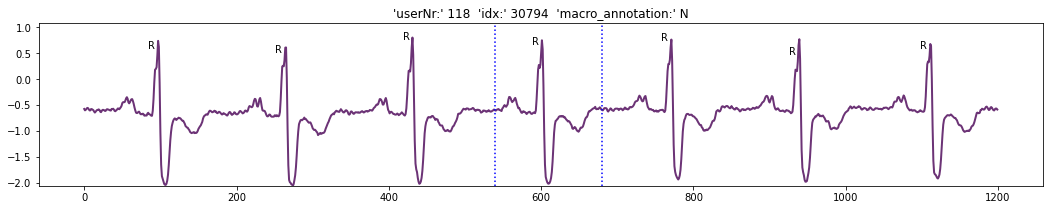

Sekos anotacijos vieta laiko ašyje: 0:25:42.755000
idx = 31260  seq_1d.shape = (140,)  label = 0
min: -2.11456, max: 0.6663  mean: -0.84390  standard: 0.43958
variance: 0.19462  skewness: -0.45165  kurtosis: 3.22053


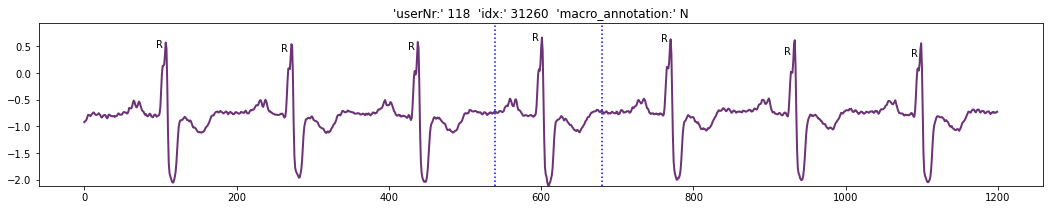

Sekos anotacijos vieta laiko ašyje: 0:16:57.960000
idx = 57715  seq_1d.shape = (140,)  label = 0
min: -0.73569, max: 1.1635  mean: -0.20124  standard: 0.23177
variance: 0.05410  skewness: 3.32161  kurtosis: 15.65548


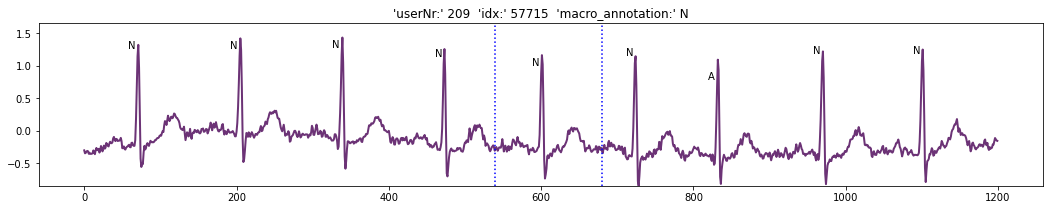

Sekos anotacijos vieta laiko ašyje: 0:12:58.745000
idx = 30333  seq_1d.shape = (140,)  label = 0
min: -1.86784, max: 0.7541  mean: -0.68200  standard: 0.40932
variance: 0.16875  skewness: -0.46527  kurtosis: 3.63751


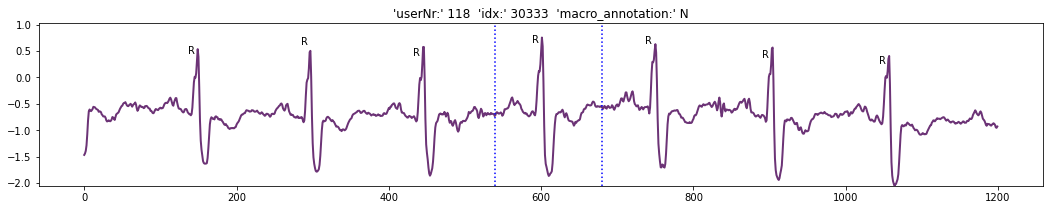

In [2]:
import random
from scipy import stats
import datetime

# UŽDUODAME PARAMETRUS VAIZDAVIMUI
wl_side = 60
wr_side = 80
window_left_side_ext = 600
window_right_side_ext = 600
number_of_pictures = 10

# Nurodome paciento Nr.

DS = [118,209]

print(f"Pacientų nr.: {DS}")

# Train imties pacientai
# DS1 = [101, 106, 108, 109, 112, 114, 115, 116, 118, 119, 122, 124, 201, 203, 205, 208, 209, 215, 220, 223,230]
# Validate imties pacientai
# DS2 = [100, 103, 105, 111, 113, 117, 121, 123, 200, 202, 210, 212, 213, 214, 219, 221, 222, 228, 231, 232, 233, 234]

# PASIRUOŠIMAS

# Nuskaitome pūpsnių atributų failą
file_path = Path(db_path, 'all_beats_attr.csv')
all_beats_attr = pd.read_csv(file_path, index_col=0)

# Visų sekų indeksų sąrašas
all_beat_indices = all_beats_attr.index
beats_skiped = 5

# Paruošiame pūpsnių atributų masyvus ir išvedame 
ind_lst = []
for userNr in DS:
    selected_ind = all_beat_indices[all_beats_attr['userNr']==userNr]
    selected_ind = selected_ind[beats_skiped:-beats_skiped]
    ind_lst.extend(selected_ind.to_list())
ds_beats_attr = all_beats_attr.loc[ind_lst]

# # VAIZDAVIMAS
nr_list = random.sample(range(0, len(ds_beats_attr)), number_of_pictures)
idx_list = list(ds_beats_attr.index[nr_list])
print(f"Pūpsnių atributų masyvo indeksų sąrašas: {idx_list}")
print("\n")

for idx in idx_list:
    id = all_beats_attr.loc[idx,'sample']/20
    seconds = all_beats_attr.loc[idx,'sample']/200.
    converted = datetime.timedelta(seconds=seconds)  # #  hour, minutes, and secondss
    print(f"Sekos anotacijos vieta laiko ašyje: {converted}")
    seq_1d, label = read_seq(db_path, all_beats_attr, idx, wl_side, wr_side)
    print(f"{'idx ='} {idx}  {'seq_1d.shape ='} {seq_1d.shape}  {'label ='} {label}")
    statistics = stats.describe(seq_1d)
    print_stats(statistics, seq_1d)
    plot_seq(db_path, all_beats_attr, idx, wl_side, wr_side, window_left_side_ext, window_right_side_ext)



In [3]:
# ANOTACIJŲ PASISKIRSTYMAS PACIENTŲ ĮRAŠUOSE

# Train imties pacientai
DS1 = [101, 106, 108, 109, 112, 114, 115, 116, 118, 119, 122, 124, 201, 203, 205, 208, 209, 215, 220, 223,230]

# Validate imties pacientai
DS2 = [100, 103, 105, 111, 113, 117, 121, 123, 200, 202, 210, 212, 213, 214, 219, 221, 222, 228, 231, 232, 233, 234]

# Nuskaitome pūpsnių atributų freimą iš rec_dir aplanko
file_path = Path(db_path, 'all_beats_attr.csv')
all_beats_attr = pd.read_csv(file_path, index_col=0)

# Visų sekų indeksų sąrašas
all_beat_indices = all_beats_attr.index
beats_skiped = 5

# MOKYMO IMTIS

train_ind_lst = []
for userNr in DS1:
    selected_ind = all_beat_indices[all_beats_attr['userNr']==userNr]
    selected_ind = selected_ind[beats_skiped:-beats_skiped]
    train_ind_lst.extend(selected_ind.to_list())

# Anotacijų pasiskirstymas mokymo duomenyse
print("\nAnotacijų pasiskirstymas mokymo duomenyse\n")
labels_table, labels_sums = anotaciju_pasiskirstymas_v2(all_beats_attr, ind_lst=train_ind_lst, cols_pattern=['N', 'S', 'V'])
print(labels_table)
print("\nTotal:", labels_sums['All'])

# VERTINIMO IMTIS
validate_ind_lst = []
for userNr in DS2:
    selected_ind = all_beat_indices[all_beats_attr['userNr']==userNr]
    selected_ind = selected_ind[beats_skiped:-beats_skiped]
    validate_ind_lst.extend(selected_ind.to_list())

# Anotacijų pasiskirstymas vertinimo duomenyse
print("\nAnotacijų pasiskirstymas vertinimo duomenyse\n")
labels_table, labels_sums = anotaciju_pasiskirstymas_v2(all_beats_attr, ind_lst=validate_ind_lst, cols_pattern=['N', 'S', 'V'])
print(labels_table)
print("\nTotal:", labels_sums['All'])



Anotacijų pasiskirstymas mokymo duomenyse

symbol      N    S     V
userNr                  
101      1850    3     0
106      1499    0   518
108      1730    4    17
109      2483    0    37
112      2527    2     0
114      1810   12    43
115      1943    0     0
116      2292    1   109
118      2158   94    16
119      1534    0   443
122      2466    0     0
124      1526   31    47
201      1626  127   198
203      2519    2   444
205      2561    3    71
208      1581    2   987
209      2611  383     1
215      3185    3   164
220      1944   94     0
223      2035   73   473
230      2245    0     1
All     44125  834  3569

Total: 48528

Anotacijų pasiskirstymas vertinimo duomenyse

symbol      N     S     V
userNr                   
100      2229    33     1
103      2072     2     0
105      2516     0    41
111      2113     0     1
113      1779     6     0
117      1524     1     0
121      1851     1     1
123      1505     0     3
200      1736    30   823
202      

In [4]:
# Micro anotacijų pasiskirstymas per visus įrašus.

annot_list = ['N','L','R','e','j','A','a','J','S','V','E','F','Q']

# Susikuriame pagalbinį anotacijų žodyną - dictionary beats_annot
nr_sequence = list(range(13))
beats_annot = dict(zip(annot_list, nr_sequence))

records = np.array([100, 101, 103, 105, 106, 108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 121, 122, 123, 124,
200, 201, 202, 203, 205, 208, 209, 210, 212, 213, 214, 215, 219, 220, 221, 222, 223, 228, 230, 231, 232, 233, 234])

# Atliekama pirminė EKG įrašų anotacijų analizė

# Pasiruošimas ciklui per pacientų įrašus
labels_rec_all = pd.DataFrame(columns=beats_annot.keys(),dtype=int)
labels_rec_all.insert(0,"subject",0)
labels_rec = []

# Pacientų įrašų sąrašas bandymams (yra dar viena vieta):
# subj_list = ['100','101', '230', '231']

# Ciklas per pacientų įrašus

for userNr in records:
    # Paciento anotacijų nuskaitymas, nustatomas anotacijų 
    # ir užduotų klasių pasiskirstymas per visus įrašus
    labels_rec = np.zeros(labels_rec_all.shape[1],dtype=int)
    labels_rec[0] = userNr

    # Nuskaitome anotacijas ir jų indeksus
    file_path = Path(db_path, str(userNr) + '.json')
    df = pd.read_json(file_path, orient = 'records')
    atr_sample = df['sampleIndex'].to_numpy()
    atr_symbol = df['annotationValue'].to_numpy()

    # Ciklas per visas paciento įrašo anotacijas (simbolius)
    for symbol in atr_symbol:
        # Gaunamas anotacijos simbolio numeris anotacijų sąraše
        label = beats_annot.get(symbol)
        if (label == None):
            continue
        labels_rec[label+1] +=1

    # Sumuojame į bendrą masyvą
    labels_rec_all.loc[len(labels_rec_all)] = labels_rec

# Ciklo per pacientų įrašus pabaiga

# Parodomas anotacijų ir užduotų klasių pasiskirstymas per visus įrašus
print("\nAnotacijų pasiskirstymas per visus įrašus\n")
print("labels_rec_all:\n")
print(labels_rec_all)
suma = labels_rec_all.iloc[:,1:].sum()
print('\n',' '*5, 'sum: ',str(suma.tolist())[1:-1])
total = suma.sum()
print(' '*5, 'total: ', total)


Anotacijų pasiskirstymas per visus įrašus

labels_rec_all:

    subject     N     L     R   e    j     A   a   J  S    V  E    F    Q
0       100  2239     0     0   0    0    33   0   0  0    1  0    0    1
1       101  1860     0     0   0    0     3   0   0  0    0  0    0   11
2       103  2082     0     0   0    0     2   0   0  0    0  0    0    7
3       105  2526     0     0   0    0     0   0   0  0   41  0    0  124
4       106  1507     0     0   0    0     0   0   0  0  520  0    0   71
5       108  1739     0     0   0    1     4   0   0  0   17  0    2   61
6       109     0  2492     0   0    0     0   0   0  0   38  0    2    3
7       111     0  2123     0   0    0     0   0   0  0    1  0    0    9
8       112  2537     0     0   0    0     2   0   0  0    0  0    0   11
9       113  1789     0     0   0    0     0   6   0  0    0  0    0    1
10      114  1820     0     0   0    0    10   0   2  0   43  0    4   11
11      115  1953     0     0   0    0     0   0   